## 꽃 이미지 분류 방법

### TensorFlow 및 기타 라이브러리 가져오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### dataset 다운로드 및 탐색

In [2]:
'''flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/'''

'flower_photo/\n  daisy/\n  dandelion/\n  roses/\n  sunflowers/\n  tulips/'

In [6]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(type(dataset_url))
print(type(data_dir))

<class 'str'>
<class 'pathlib.WindowsPath'>


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
print(type(image_count))

3670
<class 'int'>


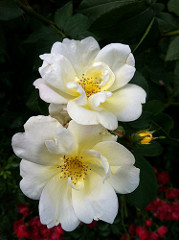

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

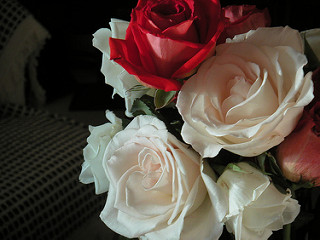

In [6]:
PIL.Image.open(str(roses[1]))

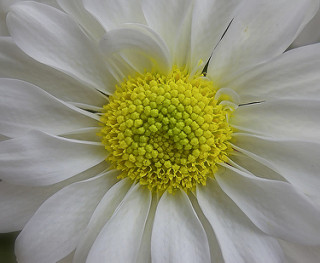

In [7]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

## keras.preprocessing을 사용하여 로드하기

### dataset 만들기

In [8]:
# 로더에 대한 몇 가지 매개변수를 정의한다.

batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 훈련에 이미지의 80%를 사용하고 검증에 20%를 사용합니다.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 class_names 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## data 시각화

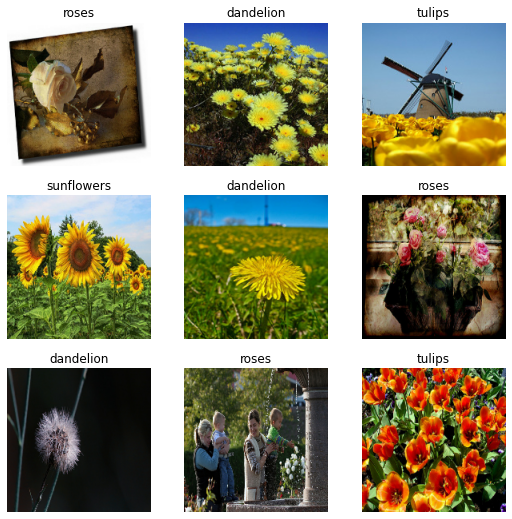

In [12]:
# train dataset의 처음 9개 이미지는 다음과 같습니다.

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

잠시 후에 이들 데이터세트를 model.fit에 전달하여 모델을 훈련하겠습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있다.

In [13]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

(32, 180, 180, 3)
(32,)


성능을 높이도록 dataset 구성하기

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

데이터 표준화하기

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### 모델 만들기

In [17]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

모델 컴파일하기

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

모델 훈련하기

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 17s 178ms/step - loss: 1.3608 - accuracy: 0.4084 - val_loss: 1.1149 - val_accuracy: 0.5572
Epoch 2/10
92/92 [==============================] - 16s 173ms/step - loss: 0.9858 - accuracy: 0.6144 - val_loss: 0.9963 - val_accuracy: 0.5817
Epoch 3/10
92/92 [==============================] - 16s 175ms/step - loss: 0.7688 - accuracy: 0.7050 - val_loss: 1.0271 - val_accuracy: 0.5804
Epoch 4/10
92/92 [==============================] - 16s 175ms/step - loss: 0.5766 - accuracy: 0.7888 - val_loss: 0.9377 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 16s 174ms/step - loss: 0.3891 - accuracy: 0.8641 - val_loss: 0.9806 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 16s 173ms/step - loss: 0.2181 - accuracy: 0.9309 - val_loss: 1.2409 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 16s 174ms/step - loss: 0.1542 - accuracy: 0.9496 - val_loss: 1.2785 - val_accuracy: 0.6471

훈련 결과 시각화하기

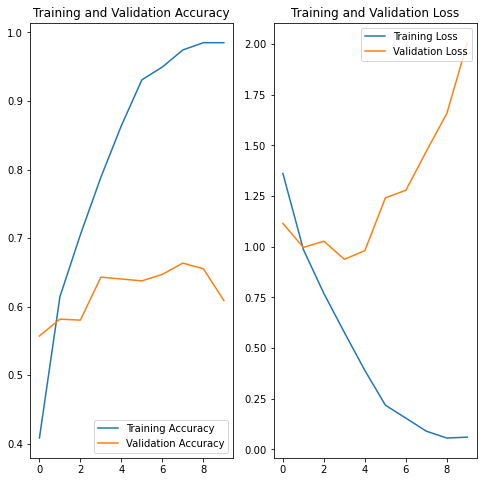

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 과대적합

데이터 증강

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

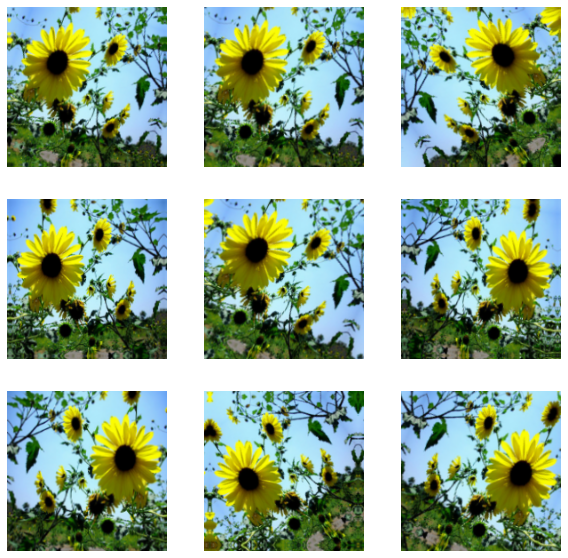

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

드롭아웃

In [24]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

모델 컴파일 및 훈련하기

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 19s 199ms/step - loss: 1.3781 - accuracy: 0.4264 - val_loss: 1.1617 - val_accuracy: 0.5259
Epoch 2/15
92/92 [==============================] - 18s 197ms/step - loss: 1.1036 - accuracy: 0.5613 - val_loss: 1.0697 - val_accuracy: 0.5681
Epoch 3/15
92/92 [==============================] - 18s 197ms/step - loss: 0.9909 - accuracy: 0.6049 - val_loss: 0.9938 - val_accuracy: 0.6063
Epoch 4/15
92/92 [==============================] - 18s 196ms/step - loss: 0.9194 - accuracy: 0.6345 - val_loss: 1.0078 - val_accuracy: 0.5886
Epoch 5/15
92/92 [==============================] - 18s 197ms/step - loss: 0.8725 - accuracy: 0.6614 - val_loss: 0.9051 - val_accuracy: 0.6240
Epoch 6/15
92/92 [==============================] - 18s 197ms/step - loss: 0.8307 - accuracy: 0.6778 - val_loss: 0.8996 - val_accuracy: 0.6649
Epoch 7/15
92/92 [==============================] - 18s 197ms/step - loss: 0.7846 - accuracy: 0.6894 - val_loss: 0.8899 - val_accuracy: 0.6499

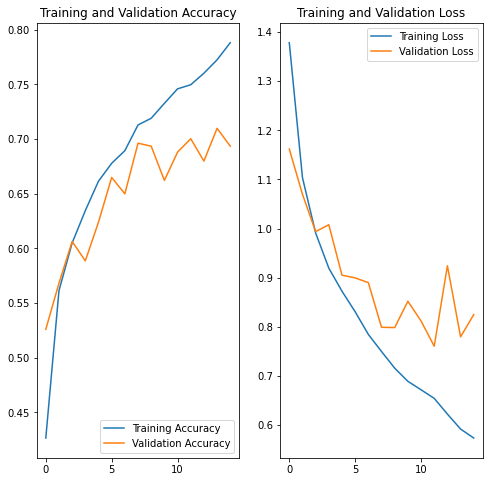

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

새로운 데이터로 예측하기

In [29]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 86.49 percent confidence.
